In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import Image as show_image
import torch
import glob
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
#np.random.seed(2000)
covid_path_test = "/content/drive/MyDrive/TechLabs/Artifical_Intelligence/DATA_splitted/TEST/covid/"
normal_path_test = "/content/drive/MyDrive/TechLabs/Artifical_Intelligence/DATA_splitted/TEST/normal/"
covid_pics_test = np.array([covid_path_test+i for i in os.listdir(covid_path_test)])
normal_pics_test = np.array([normal_path_test+i for i in os.listdir(normal_path_test)])

covid_path_train = "/content/drive/MyDrive/TechLabs/Artifical_Intelligence/DATA_splitted/TRAIN/covid/"
normal_path_train = "/content/drive/MyDrive/TechLabs/Artifical_Intelligence/DATA_splitted/TRAIN/normal/"
covid_pics_train = np.array([covid_path_train+i for i in os.listdir(covid_path_train)])
normal_pics_train = np.array([normal_path_train+i for i in os.listdir(normal_path_train)])

train_path = "/content/drive/MyDrive/TechLabs/Artifical_Intelligence/DATA_splitted/TRAIN"
test_path = "/content/drive/MyDrive/TechLabs/Artifical_Intelligence/DATA_splitted/TEST"

Covid XRay


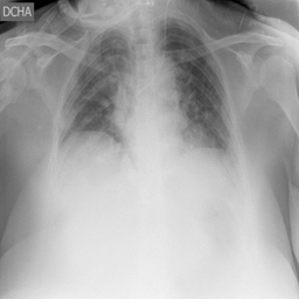

In [6]:
#Covid Image
print("Covid XRay")
show_image(covid_pics_train[0])

Normal XRay


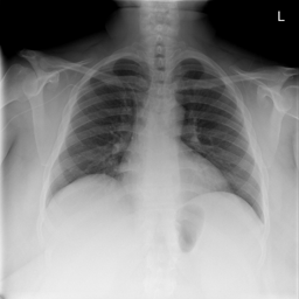

In [7]:
#Normal Image
print("Normal XRay")
show_image(normal_pics_train[0])

In [8]:
im = Image.open(covid_pics_test[100])
im = np.asarray(im)
print(im.shape)
im.shape == np.asarray(Image.open(normal_pics_train[934])).shape == np.asarray(Image.open(normal_pics_test[172])).shape

(299, 299)


True

In [9]:
print("# Normal XRays Train", len(normal_pics_train))
print("# Normal XRays Test", len(normal_pics_test))
print("# COVID XRays Train", len(covid_pics_train))
print("# COVID XRays Test", len(covid_pics_test))

# Normal XRays Train 9231
# Normal XRays Test 1000
# COVID XRays Train 2656
# COVID XRays Test 1000


In [10]:
transformer = transforms.Compose([
                transforms.Resize((200, 200)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.5,0.5,.05], [0.5,0.5,0.5])
              ])

In [11]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformer), 
    batch_size =128, shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformer), 
    batch_size = 128, shuffle = True
)

In [12]:
#root = pathlib.Path(train_path)
classes=os.listdir(train_path)
print(classes)

['normal', 'covid']


In [13]:

# Backup
class ConvNet(nn.Module):
  def __init__(self, n_classes = 2):
    super(ConvNet, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    self.relu1=nn.ReLU()
    self.pool=nn.MaxPool2d(kernel_size=2)

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
    self.relu2=nn.ReLU()

    self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(num_features=32)
    self.relu3=nn.ReLU()

    self.fc = nn.Linear(in_features=32*100*100, out_features=n_classes)


  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)
    
    output = self.pool(output)
    
    output = self.conv2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn3(output)
    output = self.relu3(output) 

    output = output.view(-1, 32*100*100)
    output = self.fc(output)
    return output


In [14]:
model = ConvNet(n_classes=2).to(device)
optimizer=Adam(model.parameters(),lr=0.001, weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [15]:
n_epochs = 10

In [16]:
train_count=len(glob.glob(train_path+"/**/*.png"))
test_count=len(glob.glob(test_path+"/**/*.png"))

In [17]:
print(train_count)
print(test_count)

11885
2000


In [18]:
# Train Model 
best_accuracy = 0.0

for epoch in range(n_epochs):
  #eval train
  model.train()
  train_accuracy = 0.0
  train_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels=Variable(labels.cuda())
      
    optimizer.zero_grad()
    
    outputs = model(images)
    loss=loss_function(outputs,labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data, 1)
    train_accuracy+= int(torch.sum(prediction==labels.data))
    
  train_accuracy=train_accuracy/train_count

  #eval test
  model.eval()
  test_accuracy =0.0
  for i, (images, labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels=Variable(labels.cuda())
    
    outputs=model(images)
    _,prediction=torch.max(outputs.data, 1)
    test_accuracy+= int(torch.sum(prediction==labels.data))
  test_accuracy=test_accuracy/test_count

  print(f"Epoch: {epoch}, Train Loss {train_loss}, Train Acc {train_accuracy}, Test Acc {test_accuracy}" )

  if test_accuracy > best_accuracy:
    torch.save(model.state_dict(), "best_checkpoint.model")
    best_accuracy = test_accuracy

Epoch: 0, Train Loss 62617.125, Train Acc 0.8074042911232646, Test Acc 0.8495
Epoch: 1, Train Loss 10864.4921875, Train Acc 0.8970971813209928, Test Acc 0.88
Epoch: 2, Train Loss 10914.5830078125, Train Acc 0.9003786285233487, Test Acc 0.716
Epoch: 3, Train Loss 5870.736328125, Train Acc 0.9342027766091712, Test Acc 0.9225
Epoch: 4, Train Loss 2135.073486328125, Train Acc 0.9609591922591502, Test Acc 0.9185
Epoch: 5, Train Loss 1485.355712890625, Train Acc 0.9714766512410602, Test Acc 0.8815
Epoch: 6, Train Loss 996.6493530273438, Train Acc 0.9783761043331931, Test Acc 0.914
Epoch: 7, Train Loss 738.31298828125, Train Acc 0.9833403449726547, Test Acc 0.9445
Epoch: 8, Train Loss 972.5618896484375, Train Acc 0.9776188472864956, Test Acc 0.918
Epoch: 9, Train Loss 523.7240600585938, Train Acc 0.9874631888935633, Test Acc 0.9265
